In [11]:
import sys
import os

# 获取当前 notebook 所在目录的父目录
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from gbp.gbp import *
from gbp.factor import *
from gbp.grid import *

Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/home/yuzhou/anaconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yuzhou/anaconda3/envs/jax-gpu/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", li

In [12]:
H = 16
W = 16
prior_noise_std=prior_std=1
odom_noise_std=odom_std=0.01
seed=0
num_iters=100




In [13]:
positions, prior_meas, between_meas = generate_grid_slam_data(H=H, W=W, 
                                    prior_noise_std=prior_noise_std, odom_noise_std=odom_noise_std, seed=seed)
varis, prior_facs, between_facs = build_pose_slam_graph(N=256, prior_meas=prior_meas, between_meas=between_meas, 
                                                        prior_std=prior_std, odom_std=odom_std,
                                                        Ni_v=10, D=2)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [14]:
varis, prior_facs, between_facs, energy_log, linpoints_log = gbp_solve(
    varis, prior_facs, between_facs, num_iters=num_iters, visualize=True
)


In [15]:
# build the coarse-level pose SLAM grid
varis_coarse, prior_facs_coarse, horizontal_facs_coarse, vertical_facs_coarse  = build_coarse_slam_graph(
    prior_facs_fine=prior_facs,
    between_facs_fine=between_facs,
    H=H, W=W,
    stride = 2,
)



In [16]:
# Solve the coarse-level grid with GBP
varis_coarse, prior_facs_coarse, horizontal_facs_coarse, vertical_facs_coarse, energy_log_coarse, linpoints_log_coarse = gbp_solve_coarse(
    varis_coarse, prior_facs_coarse, horizontal_facs_coarse, vertical_facs_coarse, 
    num_iters=num_iters, visualize=True
)


In [17]:
varis_coarser, prior_facs_coarser, horizontal_facs_coarser, vertical_facs_coarser = build_coarser_slam_graph(
    prior_facs_coarse=prior_facs_coarse,
    horizontal_between_facs=horizontal_facs_coarse,
    vertical_between_facs=vertical_facs_coarse,
    H=H, W=W,
    stride=2
)


In [18]:
# Solve the coarser-level grid with GBP
varis_coarser, prior_facs_coarser, horizontal_facs_coarser, vertical_facs_coarser, energy_log_coarser, linpoints_log_coarser = gbp_solve_coarse(
    varis_coarser, prior_facs_coarser, horizontal_facs_coarser, vertical_facs_coarser, 
    num_iters=num_iters, visualize=True, prior_h=h6_fn, between_h=[h7_fn,h8_fn]
)


In [19]:
print(energy_log[-30:])
print(energy_log_coarse[-30:])
print(energy_log_coarser[-30:])

[304.653   303.72025 302.82208 301.95255 301.1144  300.30237 299.51855
 298.7581  298.02313 297.30948 296.6187  295.9471  295.29684 294.6639
 294.05    293.4519  292.87122 292.30463 291.75403 291.2165  290.69345
 290.18216 289.68445 289.19772 288.72296 288.25836 287.8048  287.36078
 286.92688 286.50177]
[261.208   260.99493 260.78998 260.59232 260.4024  260.21933 260.04318
 259.8732  259.70993 259.55243 259.40112 259.25513 259.11472 258.97937
 258.84918 258.72372 258.60306 258.4867  258.37485 258.2669  258.1632
 258.06323 257.96698 257.8742  257.78506 257.69913 257.61642 257.53674
 257.46005 257.38614]
[255.47037 255.4703  255.47026 255.47021 255.47015 255.47014 255.47008
 255.47008 255.47005 255.47005 255.47002 255.47003 255.47    255.46999
 255.46999 255.47    255.46999 255.46997 255.46997 255.46996 255.46996
 255.46996 255.46997 255.46996 255.46996 255.46996 255.46996 255.46996
 255.46996 255.46992]


In [20]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Function to ensure only point visibility is toggled by buttons,
# while energy curves always stay visible (last 3 traces)
def make_visibility(show_fine, show_coarse, show_coarser):
    return [show_fine, show_coarse, show_coarser, True, True, True]

# Compute overall axis bounds for equal scaling
all_points = np.concatenate([
    linpoints_log.reshape(-1, 2),
    linpoints_log_coarse.reshape(-1, 2),
    linpoints_log_coarser.reshape(-1, 2)
], axis=0)

x_min, y_min = all_points.min(axis=0)
x_max, y_max = all_points.max(axis=0)

x_range = x_max - x_min
y_range = y_max - y_min
max_range = max(x_range, y_range) / 2

x_center = (x_max + x_min) / 2
y_center = (y_max + y_min) / 2

x_min_equal = x_center - max_range - 0.001 * max_range
x_max_equal = x_center + max_range + 0.001 * max_range
y_min_equal = y_center - max_range - 0.001 * max_range
y_max_equal = y_center + max_range + 0.001 * max_range

# Dimensions
num_iters = linpoints_log.shape[0]
fine_points = linpoints_log.shape[1]
coarse_points = linpoints_log_coarse.shape[1]
coarser_points = linpoints_log_coarser.shape[1]

# Assign colors to each point group
fine_base = px.colors.qualitative.Set3
fine_colors = (fine_base * ((fine_points // len(fine_base)) + 1))[:fine_points]
coarse_colors = px.colors.qualitative.Plotly * 10
coarser_colors = px.colors.qualitative.D3 * 10

# Precompute color assignments per point
coarse_color_list = [coarse_colors[i] for i in range(coarse_points) for _ in range(4)]
coarser_color_list = [coarser_colors[i] for i in range(coarser_points) for _ in range(16)]

# Create animation frames
frames = []
for t in range(num_iters):
    # Fine-level points (right side)
    fine_trace = go.Scatter(
        x=linpoints_log[t, :, 0],
        y=linpoints_log[t, :, 1],
        mode='markers',
        marker=dict(size=4, color=fine_colors),
        name='fine',
        showlegend=False,
        xaxis='x1',
        yaxis='y1'
    )

    # Coarse-level points (right side)
    coarse_pts = linpoints_log_coarse[t].reshape(-1, 2)
    coarse_trace = go.Scatter(
        x=coarse_pts[:, 0],
        y=coarse_pts[:, 1],
        mode='markers',
        marker=dict(size=4, color=coarse_color_list),
        name='coarse',
        showlegend=False,
        xaxis='x1',
        yaxis='y1'
    )

    # Coarser-level points (right side)
    coarser_pts = linpoints_log_coarser[t].reshape(-1, 2)
    coarser_trace = go.Scatter(
        x=coarser_pts[:, 0],
        y=coarser_pts[:, 1],
        mode='markers',
        marker=dict(size=4, color=coarser_color_list),
        name='coarser',
        showlegend=False,
        xaxis='x1',
        yaxis='y1'
    )

    # Sliding window for energy plot (left bottom)
    start_idx = max(0, t - 4)
    x_vals = np.arange(start_idx, t + 1)

    # Energy curves: fine, coarse, coarser
    energy_trace_fine = go.Scatter(
        x=x_vals,
        y=energy_log[start_idx:t + 1],
        mode='lines+markers',
        line=dict(color='pink'),
        marker=dict(size=3),
        name='Energy Fine',
        xaxis='x2',
        yaxis='y2',
        showlegend=False
    )

    energy_trace_coarse = go.Scatter(
        x=x_vals,
        y=energy_log_coarse[start_idx:t + 1],
        mode='lines+markers',
        line=dict(color='lightblue'),
        marker=dict(size=3),
        name='Energy Coarse',
        xaxis='x2',
        yaxis='y2',
        showlegend=False
    )

    energy_trace_coarser = go.Scatter(
        x=x_vals,
        y=energy_log_coarser[start_idx:t + 1],
        mode='lines+markers',
        line=dict(color='lightgreen'),
        marker=dict(size=3),
        name='Energy Coarser',
        xaxis='x2',
        yaxis='y2',
        showlegend=False
    )

    # Dynamic y-range for zoomed-in energy chart
    dynamic_ymax = max(
        energy_log[start_idx:t + 1].max(),
        energy_log_coarse[start_idx:t + 1].max(),
        energy_log_coarser[start_idx:t + 1].max()
    )
    dynamic_ymin = min(
        energy_log[start_idx:t + 1].min(),
        energy_log_coarse[start_idx:t + 1].min(),
        energy_log_coarser[start_idx:t + 1].min()
    )


    # Create and append this frame
    frames.append(go.Frame(
        name=str(t),
        data=[
            fine_trace, coarse_trace, coarser_trace,
            energy_trace_fine, energy_trace_coarse, energy_trace_coarser
        ],
        layout=go.Layout(
            xaxis2=dict(range=[start_idx, t], domain=[0.1, 0.35], anchor='y2'),
            yaxis2=dict(range=[0, dynamic_ymax], domain=[0, 0.45], anchor='x2')
        )
    ))

# Static layout (position and energy plots, animation buttons)
layout = go.Layout(
    width=1000,
    height=650,
    title=dict(
        text='Multi-Scale GBP Animation',
        x=0.5,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(family='Times New Roman, serif', size=20, color='black')
    ),
    margin=dict(l=0, r=0, t=0.2 * 650, b=0.1 * 650),


    annotations=[
        dict(
            x=0.98, y=0.95,
            xref='x2 domain', yref='y2 domain',
            text="<span style='color:pink; font-size:10px;'>Fine</span><br>"
                "<span style='color:lightblue; font-size:10px;'>Coarse</span><br>"
                "<span style='color:lightgreen; font-size:10px;'>Coarser</span>",
            showarrow=False,
            align='right',
            bgcolor='rgba(255,255,255,0.6)',
            bordercolor='lightgray',
            borderwidth=0.5,
            borderpad=2,
        )
    ],


    # Main position plot (right)
    xaxis1=dict(range=[x_min_equal, x_max_equal], domain=[0.4, 1], constrain='domain', anchor='y1'),
    yaxis1=dict(range=[y_min_equal, y_max_equal], domain=[0, 1], scaleanchor='x1', scaleratio=1, anchor='x1'),

    # Energy plot (left-bottom)
    xaxis2=dict(domain=[0.1, 0.35], anchor="y2", title="Iteration", automargin=False),
    yaxis2=dict(domain=[0, 0.45], anchor="x2", title="Energy", automargin=False),

    # Button menus
    updatemenus=[
        {
            "type": "buttons",
            "direction": "down",
            "x": 0.44,
            "xanchor": "right",
            "y": 0.6,
            "yanchor": "top",
            "pad": {"r": 0, "t": 0},
            "buttons": [
                {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"mode": "immediate", "frame": {"duration": 0, "redraw": False}, "transition": {"duration": 0}}]},
                {"label": "Stop", "method": "animate", "args": [["0"], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}}]}
            ]
        },
        {
            "type": "buttons",
            "direction": "right",
            "x": 0.6,
            "xanchor": "left",
            "y": 1.1,
            "yanchor": "top",
            "pad": {"r": 0, "t": 0},
            "buttons": [
                {"label": "Fine", "method": "update", "args": [{"visible": make_visibility(True, False, False)}]},
                {"label": "Coarse", "method": "update", "args": [{"visible": make_visibility(False, True, False)}]},
                {"label": "Coarser", "method": "update", "args": [{"visible": make_visibility(False, False, True)}]}
            ]
        }
    ]


    
)

# Create and display figure


fig = go.Figure(data=frames[0].data, frames=frames, layout=layout)
fig.show()


In [21]:
mu = varis_coarser.belief.mu()[0]
Sigma = varis_coarser.belief.sigma()[0]

In [ ]:
#U, S, Vh = np.linalg.svd(lam1, full_matrices=False)
#S

In [ ]:
import numpy as np

# Create an empty list to store the reduced mean (2D) for each variable
mu_reduced_list = []

# Loop through each coarser-level variable (assumed to be 16 in total)
for i in range(16):

    # Get the natural parameters (eta) and precision matrix (Lam) of the i-th variable
    eta = varis_coarser.belief.eta[i]    # eta: shape (32,)
    Lam = varis_coarser.belief.Lam[i]    # Lam: shape (32, 32), symmetric positive definite

    # Step 1: Perform eigenvalue decomposition of the precision matrix
    # eigh is used for symmetric matrices to ensure numerical stability and real eigenvalues
    eigvals, eigvecs = np.linalg.eigh(Lam)

    # Step 2: Sort eigenvalues and eigenvectors in descending order of eigenvalues
    idx = np.argsort(eigvals)[::-1]      # Get indices of sorted eigenvalues (largest first)
    eigvals = eigvals[idx]               # Reorder eigenvalues
    eigvecs = eigvecs[:, idx]            # Reorder corresponding eigenvectors

    # Step 3: Select the top-k eigenvectors to form the projection matrix (principal subspace)
    k = 2
    V_k = eigvecs[:, :2]                 # V_k: shape (32, 2), projects 32D to 2D

    # Step 4: Project eta and Lam onto the reduced 2D subspace
    # This gives the natural parameters of the reduced 2D Gaussian
    eta_reduced = V_k.T @ eta            # Projected natural mean: shape (2,)
    Lam_reduced = V_k.T @ Lam @ V_k      # Projected precision matrix: shape (2, 2)

    # Step 5: Convert the reduced natural parameters back to mean in 2D
    mu_reduced = np.linalg.inv(Lam_reduced) @ eta_reduced   # shape (2,)

    # Store the reduced mean for later use
    mu_reduced_list.append(mu_reduced)



In [38]:
linpoints_log_coarser.shape

(100, 16, 32)

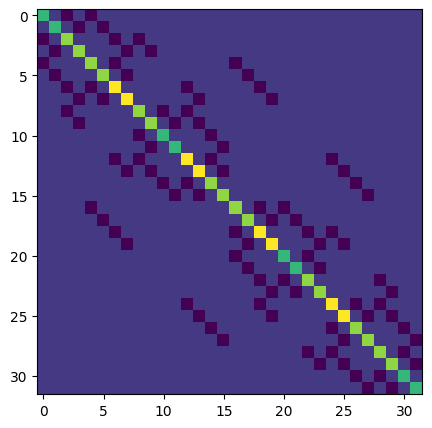

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 J 是你的 80x32 矩阵
# 示例：随机生成一个矩阵
# J = np.random.randn(80, 32)

xs = linpoints_log_coarser[99,1]
h = h6_fn(xs)
J = jax.jacrev(h6_fn)(xs).reshape(h.size, xs.size)

plt.figure(figsize=(5, 5))  # 可以根据需要调整图像大小
plt.imshow(J.T@J)  # 'bwr' 是红蓝色图谱，突出正负

plt.show()


In [66]:
J.T@J


eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(J.T@J))

# Step 2: Sort eigenvalues and eigenvectors in descending order of eigenvalues
idx = np.argsort(eigvals)[::-1]      # Get indices of sorted eigenvalues (largest first)
eigvals = eigvals[idx]               # Reorder eigenvalues
eigvecs = eigvecs[:, idx]            # Reorder corresponding eigenvectors

# Step 3: Select the top-k eigenvectors to form the projection matrix (principal subspace)
k = 2
V_k = eigvecs[:, :2]                 # V_k: shape (32, 2), projects 32D to 2D

# Step 4: Project eta and Lam onto the reduced 2D subspace
# This gives the natural parameters of the reduced 2D Gaussian
mu_reduced = V_k.T @ linpoints_log_coarser[99,4]            # Projected natural mean: shape (2,)

mu_reduced

array([  5.7689633, -21.913765 ], dtype=float32)

In [53]:
eigvals

array([7.8284273, 7.8284273, 6.4142137, 6.4142137, 6.4142137, 6.4142137,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       4.4142137, 4.4142137, 4.4142137, 4.4142137, 3.5857863, 3.5857863,
       3.5857863, 3.5857863, 3.       , 3.       , 3.       , 3.       ,
       2.171573 , 2.171573 , 1.5857865, 1.5857865, 1.5857865, 1.5857865,
       1.       , 1.       ], dtype=float32)

array([[ 5.06741823e-15, -7.32233077e-02],
       [ 7.32233077e-02,  4.96824804e-15],
       [-1.22471477e-14,  1.76776692e-01],
       [-1.76776692e-01, -1.19904087e-14],
       [-1.21916366e-14,  1.76776692e-01],
       [-1.76776692e-01, -1.22476331e-14],
       [ 2.94902991e-14, -4.26776707e-01],
       [ 4.26776707e-01,  2.95742943e-14],
       [ 1.23512311e-14, -1.76776692e-01],
       [ 1.76776692e-01,  1.21507986e-14],
       [-5.00988140e-15,  7.32233077e-02],
       [-7.32233077e-02, -5.02734637e-15],
       [-2.99760217e-14,  4.26776707e-01],
       [-4.26776707e-01, -2.94859860e-14],
       [ 1.21985755e-14, -1.76776692e-01],
       [ 1.76776692e-01,  1.22779298e-14],
       [ 1.20528587e-14, -1.76776692e-01],
       [ 1.76776692e-01,  1.22468250e-14],
       [-2.90878432e-14,  4.26776707e-01],
       [-4.26776707e-01, -2.96131595e-14],
       [-5.12090370e-15,  7.32233077e-02],
       [-7.32233077e-02, -5.12591221e-15],
       [ 1.18655086e-14, -1.76776692e-01],
       [ 1.

In [36]:
prior_facs_coarser.z


mu_reduced_list = []
for i in range(16):

    # Get the natural parameters (eta) and precision matrix (Lam) of the i-th variable
    mu = prior_facs_coarser.z[i]    # eta: shape (80,)
    variance = jnp.linalg.inv(prior_facs_coarser.z_Lam[i])    # Lam: shape (80, 80), symmetric positive definite

    # Step 1: Perform eigenvalue decomposition of the precision matrix
    # eigh is used for symmetric matrices to ensure numerical stability and real eigenvalues
    eigvals, eigvecs = np.linalg.eigh(variance)

    # Step 2: Sort eigenvalues and eigenvectors in descending order of eigenvalues
    idx = np.argsort(eigvals)[::-1]      # Get indices of sorted eigenvalues (largest first)
    eigvals = eigvals[idx]               # Reorder eigenvalues
    eigvecs = eigvecs[:, idx]            # Reorder corresponding eigenvectors

    # Step 3: Select the top-k eigenvectors to form the projection matrix (principal subspace)
    k = 2
    V_k = eigvecs[:, :2]                 # V_k: shape (32, 2), projects 32D to 2D

    # Step 4: Project eta and Lam onto the reduced 2D subspace
    # This gives the natural parameters of the reduced 2D Gaussian
    mu_reduced = V_k.T @ mu            # Projected natural mean: shape (2,)
    variance_reduced = V_k.T @ variance @ V_k      # Projected precision matrix: shape (2, 2)

    # Store the reduced mean for later use
    mu_reduced_list.append(mu_reduced)

In [37]:
mu_reduced_list

[Array([-1.3023027 ,  0.65208787], dtype=float32),
 Array([-0.22250964,  3.2937298 ], dtype=float32),
 Array([-0.57166815,  8.104533  ], dtype=float32),
 Array([-2.7262826, 12.365678 ], dtype=float32),
 Array([-6.544771 ,  1.9494208], dtype=float32),
 Array([-4.3184056,  5.920859 ], dtype=float32),
 Array([-7.223403,  8.544468], dtype=float32),
 Array([-4.7329493, 11.895617 ], dtype=float32),
 Array([-7.8631086 ,  0.37191245], dtype=float32),
 Array([-9.680179,  4.600551], dtype=float32),
 Array([-7.922256 ,  7.6657414], dtype=float32),
 Array([-9.107306, 12.61512 ], dtype=float32),
 Array([-12.876278,   2.519995], dtype=float32),
 Array([-14.416906,   5.943046], dtype=float32),
 Array([-12.92174 ,   8.028895], dtype=float32),
 Array([-13.964612,  12.914069], dtype=float32)]

In [9]:
def if_valid(list, N=8):
    if len(set(list)) != N:
        return False
    diagonal_list = [0 for i in range(2*N-1)]
    antidiagonal_list = [0 for i in range(2*N-1)]
    for i,element in enumerate(list):
        diagonal_list[element-i+N-1] += 1
        antidiagonal_list[element+i] += 1

    for i in range(2*N-1):
        if diagonal_list[i] > 1 or antidiagonal_list[i] > 1:
            return False
    return True

def generate_all_permutation(N=8):
    from itertools import permutations
    return list(permutations(range(N)))            
        
all_solutions = []
for i, perm in enumerate(generate_all_permutation(8)):
    if if_valid(perm, N=8):
        all_solutions.append(perm)

len(all_solutions)

92